In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression


In [2]:
N = 2000
molar_mass_R32= 0.05202 #kg/mol

In [3]:
kb = 0.0019872067        # kB in Kcal/mole/K
kb_si = 1.380649e-23  # kb in si units
R   = 8.3144626733792 # J/mol/K
kcal_per_mole_2_Joules = 6.947695411e-21   # using 1 kcal = 4184 J # 1 kcal/mol = 4184/Avogadr_num J
kcal_2_J = 4184
Angstrom_cube_2_m_cube = 1e-30
Avg_num = 6.0221408e23
atm2Pa = 101325
bar2Pa = 100000
Molar_Energy_real2SI = kcal_2_J/N

In [4]:
def yvsx(pos, slope, intercept):
  return slope * pos + intercept

def slope_yvsx(x, y, err_y):
  popt, pconv = curve_fit(yvsx, x, y, sigma=err_y,absolute_sigma=True)
  slope = popt[0]
  intercept = popt[1]
  d_slope = np.sqrt(pconv[0][0])
  d_inter = np.sqrt(pconv[1][1])
  return slope, intercept, d_slope, d_inter

def slope_val_UQ(x, y, y_error):
  fitting_data = slope_yvsx(x, y, y_error)
  data_slope = fitting_data[0]
  data_intercept = fitting_data[1]
  data_std_error = fitting_data[2]
  return data_slope, data_std_error

In [5]:
all_data_points = 5
num_rho_sets = 3

In [6]:
Press = np.array([2.714131 ,   4.88575581, 8.07277665, 16.90142294, 24.79134219 ,35.21360797]) * 100000
# -0.74%, 0.10%, -0.72%, 0.03%  ave = 0.4%

Cp_ideal_all = np.array([38.686, 39.543, 40.459 , 42.106])
Cv_ideal_all = Cp_ideal_all - R
versions = np.array(["52", "37", "36", "23", "RABBE"])


Temps = np.array([223.15, 233.15, 243.15, 258.15, 248.15, 263.15, 273.15, 298.15])
Temp_state_point = np.array([243.15, 258.15, 273.15, 298.15])
Temp_statepoint_id = np.array(["243", "258", "273", "298"])
temp = np.array(["223", "233", "243", "258", "248", "263", "273", "298"])
press = np.array(["243", "258", "273", "298", "313", "328"])


In [7]:
def Bridgman_post_processing(version):
  data_points = 3

  Hconfig_all = np.zeros((len(Temp_state_point), all_data_points))
  Hconfig_error_all = np.zeros((len(Temp_state_point), all_data_points))

  Temp_all = np.zeros((len(Temp_state_point), all_data_points))
  Press_all = np.zeros((len(Temp_state_point), all_data_points))
  rho_all = np.zeros((num_rho_sets, len(Temp_state_point), all_data_points))

  Cp_res = np.zeros(len(Temp_state_point))
  Cp_total = np.zeros(len(Temp_state_point))
  Cp_error = np.zeros(len(Temp_state_point))


  for j in range(len(Temp_state_point)):
    index = 0
    for i in range(len(temp)):
      if Temp_statepoint_id[j] == temp[i]:
        index = i

    for k in range(data_points):  
      Hconfig_all[j,k] = np.loadtxt(f"ave_Hconfig_R32_v{version}_2000mol_nptBridgman_{temp[index-2+k]}K_{press[j]}P.txt")
      Hconfig_error_all[j,k] = np.loadtxt(f"ave_Hconfig_percent_error_R32_v{version}_2000mol_nptBridgman_{temp[index-2+k]}K_{press[j]}P.txt")\
                                                              *(Hconfig_all[j,k]/100)
      Temp_all[j,k] = float(temp[index-2+k]) + 0.15
      Press_all[j,k] = Press[j]


    for l in range(data_points, all_data_points, 1):
      Hconfig_all[j,l] = np.loadtxt(f"ave_Hconfig_R32_v{version}_2000mol_nptBridgman_{temp[index]}K_{press[j+l-2]}P.txt")
      Hconfig_error_all[j,l] = np.loadtxt(f"ave_Hconfig_percent_error_R32_v{version}_2000mol_nptBridgman_{temp[index]}K_{press[j+l-2]}P.txt")\
                                                            *(Hconfig_all[j,l]/100)
      Temp_all[j,l] = float(temp[index]) + 0.15
      Press_all[j,l] = Press[j+l-2]


    Cp_res_data = slope_val_UQ(Temps[0+index-2:3+index-2], Hconfig_all[j,0:3],  Hconfig_error_all[j,0:3])
    Cp_res[j] = Cp_res_data[0]
    Cp_total[j]= Cp_res[j] + Cp_ideal_all[j]
    Cp_error[j] = Cp_res_data[1]  

  for k in range(num_rho_sets):
    for j in range(len(Temp_state_point)):
      index = 0
      for i in range(len(temp)):
        if Temp_statepoint_id[j] == temp[i]:
          index = i

      for l in range(data_points): 
        rho =  np.loadtxt(f"ave_density_array_R32_v{version}_2000mol_nptBridgman_{temp[index-2+l]}K_{press[j]}P.txt")
        rho_all[k,j,l] = rho[k]


      for m in range(data_points, all_data_points, 1):
        rho = np.loadtxt(f"ave_density_array_R32_v{version}_2000mol_nptBridgman_{temp[index]}K_{press[j+m-2]}P.txt")
        rho_all[k,j,m] = rho[k]


  return Cp_total, Cp_error, Hconfig_all, Hconfig_error_all, Temp_all, Press_all, rho_all

In [8]:
rho_all_dpoints = np.zeros((len(versions), num_rho_sets, len(Temp_state_point), all_data_points))
Temp_all_dpoints = np.zeros((len(versions), len(Temp_state_point), all_data_points))
Press_all_dpoints = np.zeros((len(versions), len(Temp_state_point), all_data_points))
rho_all = np.zeros((len(versions), num_rho_sets, len(Temp_state_point)))


Cp_all = np.zeros((len(versions), len(Temp_state_point)))
Cp_error_all = np.zeros((len(versions), len(Temp_state_point)))


for v in range(len(versions)):
  Cp_all[v,:] = Bridgman_post_processing(versions[v])[0]
  Cp_error_all[v,:] = Bridgman_post_processing(versions[v])[1]

  rho_all[v,:,:] = Bridgman_post_processing(versions[v])[-1][:,:,2]

  rho_all_dpoints[v,:,:,:] = Bridgman_post_processing(versions[v])[-1]

  Temp_all_dpoints[v,:,:] = Bridgman_post_processing(versions[v])[-3]
  Press_all_dpoints[v,:,:] = Bridgman_post_processing(versions[v])[-2]

In [9]:
def normalize(x):
  max_x = np.max(x)
  min_x = np.min(x)
  range_x = max_x - min_x
  x_norm = np.zeros(len(x))
  for i in range(len(x)):
    x_norm[i] = (x[i] - min_x)/(range_x)
  return x_norm, range_x, min_x

In [10]:
num_var_EOS = 3
EOS_data_alltemps = np.zeros((len(versions), num_rho_sets, num_var_EOS, (len(Temp_state_point)*all_data_points)))

for v in range(len(versions)):
  for k in range(num_rho_sets):
    for i in range(len(Temp_state_point)):
      EOS_data_alltemps[v,k,0,i*5:i*5+all_data_points] = rho_all_dpoints[v,k,i,:]
      EOS_data_alltemps[v,k,1,i*5:i*5+all_data_points] = Temp_all_dpoints[v,i,:]
      EOS_data_alltemps[v,k,2,i*5:i*5+all_data_points] = Press_all_dpoints[v,i,:]


In [11]:
column_to_pop = []

for i in range(len(EOS_data_alltemps[0,0,0,:])):
  for j in range(len(EOS_data_alltemps[0,0,0,:])):
    if EOS_data_alltemps[0,0,0,i] == EOS_data_alltemps[0,0,0,j] and j > i:
      column_to_pop.append(j)

EOS_data_alltemps = np.delete(EOS_data_alltemps, column_to_pop, 3)

In [12]:
#print(EOS_data_alltemps)

In [13]:
EOS_data_alltemps_norm = np.zeros((len(versions), num_rho_sets, num_var_EOS, (len(EOS_data_alltemps[0,0,0,:]))))
range_EOS_var = np.zeros(num_var_EOS - 1)
min_EOS_var = np.zeros(num_var_EOS - 1)

for v in range(len(versions)):
  for r in range(num_rho_sets):
    EOS_data_alltemps_norm[v,r,0,:] = EOS_data_alltemps[v,r,0,:]
    for i in range(num_var_EOS - 1):
      EOS_data_alltemps_norm[v,r,i+1,:] = normalize(EOS_data_alltemps[v,r,i+1,:])[0]

  for j in range(num_var_EOS - 1):
    range_EOS_var[j] = normalize(EOS_data_alltemps[0,0,j+1,:])[1]
    min_EOS_var[j] = normalize(EOS_data_alltemps[0,0,j+1,:])[2]


In [14]:
#print(EOS_data_alltemps_norm)

In [15]:
'''
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot3D(EOS_data_alltemps_norm[0,2,:], EOS_data_alltemps_norm[0,1,:], EOS_data_alltemps_norm[0,0,:], 'gray')
ax.scatter3D(EOS_data_alltemps_norm[0,2,:], EOS_data_alltemps_norm[0,1,:], EOS_data_alltemps_norm[0,0,:])
'''

"\nfrom mpl_toolkits import mplot3d\n\nfig = plt.figure()\nax = plt.axes(projection='3d')\n\nax.plot3D(EOS_data_alltemps_norm[0,2,:], EOS_data_alltemps_norm[0,1,:], EOS_data_alltemps_norm[0,0,:], 'gray')\nax.scatter3D(EOS_data_alltemps_norm[0,2,:], EOS_data_alltemps_norm[0,1,:], EOS_data_alltemps_norm[0,0,:])\n"

In [16]:
def EOS_cubic(X, a0, a1, a2, a3, a4, a5, a6, a7, a8, a9):
  T,P = X
  rho = a0 + a1*T + a2*P + a3*T**2 + a4*P**2 + a5*P*T + a6*T**3 + a7*P**3 + a8*T*P**2 + a9*P*T**2
  return rho


def EOS_quad(X, a0, a1, a2, a3, a4, a5):
  T,P = X
  rho = a0 + a1*T + a2*P + a3*T**2 + a4*P**2 + a5*P*T
  return rho


def EOS_lin(X, a0, a1, a2):
  T,P = X
  rho = a0 + a1*T + a2*P 
  return rho


def EOS_powerlaw1(X, a0, a1, a2, a3):
  T,P = X
  rho = a0 + a1*(T**(a2))*(P**(a3))
  return rho


def EOS_powerlaw2(X, a0, a1, a2, a3, a4, a5, a6, a7):
  T,P = X
  rho = a0 + a1*(T**(a2))*(P**(a3)) + a4*(T**(a5)) + a6*(P**(a7))
  return rho



def EOS_fourthorder(X, a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12, a13, a14):
  T,P = X
  rho = a0 + a1*T + a2*P + a3*T**2 + a4*P**2 + a5*P*T + a6*T**3 + a7*P**3 + a8*T*P**2 + a9*P*T**2 + a10*P**4\
          + a11*T**4 + a12*(P**1)*T**3 + a13*(P**2)*T**2 + a14*(P**3)*T 
  return rho


def EOS_fit(T, P, rho, func):
  popt, pconv = curve_fit(func, (T,P), rho, maxfev = 1000000)
  opt_params = popt
  return opt_params
  

In [17]:
num_cubic_EOS_params = 10
EOS_cubic_params = np.zeros((len(versions), num_rho_sets, num_cubic_EOS_params))

for v in range(len(versions)):
  for r in range(num_rho_sets):
    cubic_params = EOS_fit(EOS_data_alltemps_norm[v,r,1,:], EOS_data_alltemps_norm[v,r,2,:], EOS_data_alltemps_norm[v,r,0,:], EOS_cubic)
    EOS_cubic_params[v,r,:] = cubic_params

EOS_cubic_params = np.array(EOS_cubic_params)


In [18]:
#print(EOS_cubic_params)

In [19]:
#print(EOS_cubic_params_error)

In [20]:
'''
rho_cubic_EOS = np.zeros((len(versions), len(EOS_data_alltemps[0,0,:])))  
for v in range(len(versions)):
  for i in range(len(EOS_data_alltemps[0,0,:])):
    T = EOS_data_alltemps_norm[v,1,:]
    P = EOS_data_alltemps_norm[v,2,:]
    a = EOS_cubic_params[v,:]
    rho_cubic_EOS[v,i] = a[0] + a[1]*T[i] + a[2]*P[i] + a[3]*T[i]**2 + a[4]*P[i]**2 + a[5]*P[i]*T[i] + a[6]*T[i]**3 \
                            + a[7]*P[i]**3 + a[8]*T[i]*P[i]**2 + a[9]*P[i]*T[i]**2                                 
'''

'\nrho_cubic_EOS = np.zeros((len(versions), len(EOS_data_alltemps[0,0,:])))  \nfor v in range(len(versions)):\n  for i in range(len(EOS_data_alltemps[0,0,:])):\n    T = EOS_data_alltemps_norm[v,1,:]\n    P = EOS_data_alltemps_norm[v,2,:]\n    a = EOS_cubic_params[v,:]\n    rho_cubic_EOS[v,i] = a[0] + a[1]*T[i] + a[2]*P[i] + a[3]*T[i]**2 + a[4]*P[i]**2 + a[5]*P[i]*T[i] + a[6]*T[i]**3                             + a[7]*P[i]**3 + a[8]*T[i]*P[i]**2 + a[9]*P[i]*T[i]**2                                 \n'

In [21]:
'''
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D, proj3d

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot3D(EOS_data_alltemps[0,1,:], EOS_data_alltemps[0,2,:], EOS_data_alltemps[0,0,:], 'gray', label = 'eos_data_md')
ax.scatter3D(EOS_data_alltemps[0,1,:], EOS_data_alltemps[0,2,:], rho_cubic_EOS[0,:], label = 'eos_cubic_fit')

f = lambda x,y,z: proj3d.proj_transform(x,y,z, ax.get_proj())[:2]
ax.legend(loc="lower left", bbox_to_anchor=f(150,3e6,1.5e3), bbox_transform=ax.transData, ncol=2)
'''

'\nfrom mpl_toolkits import mplot3d\nfrom mpl_toolkits.mplot3d import Axes3D, proj3d\n\nfig = plt.figure()\nax = plt.axes(projection=\'3d\')\n\nax.plot3D(EOS_data_alltemps[0,1,:], EOS_data_alltemps[0,2,:], EOS_data_alltemps[0,0,:], \'gray\', label = \'eos_data_md\')\nax.scatter3D(EOS_data_alltemps[0,1,:], EOS_data_alltemps[0,2,:], rho_cubic_EOS[0,:], label = \'eos_cubic_fit\')\n\nf = lambda x,y,z: proj3d.proj_transform(x,y,z, ax.get_proj())[:2]\nax.legend(loc="lower left", bbox_to_anchor=f(150,3e6,1.5e3), bbox_transform=ax.transData, ncol=2)\n'

In [22]:
actual_temps_state_points = np.array([243.15, 258.15, 273.15, 298.15])
actual_press_state_points = np.array([2.27246138,  4.05171033, 6.67537092, 13.78266126]) * 100000


TEC_cubic_EOS_array = np.zeros((len(versions), num_rho_sets, len(actual_temps_state_points)))
#IC_cubic_EOS_array = np.zeros((len(versions), num_rho_sets, len(actual_temps_state_points)))

for v in range(len(versions)):
  for r in range(num_rho_sets):
    for i in range(len(actual_temps_state_points)):
      T = (actual_temps_state_points - min_EOS_var[0])/(range_EOS_var[0])
      P = (actual_press_state_points - min_EOS_var[1])/(range_EOS_var[1])
      a = EOS_cubic_params[v,r,:]

      drho_dT = a[1] + 2*a[3]*T[i] + a[5]*P[i] + 3*a[6]*(T[i])**2 + a[8]*(P[i])**2 + 2*a[9]*P[i]*T[i] 
      drho_dP = a[2] + 2*a[4]*P[i] + a[5]*T[i] + 3*a[7]*(P[i])**2 + a[9]*(T[i])**2 + 2*a[8]*P[i]*T[i] 
      inv_rho = 1/(rho_all[v,r,i])
      TEC_cubic_EOS_array[v,r,i] = -inv_rho * (drho_dT/range_EOS_var[0])
      #IC_cubic_EOS_array[v,r,i] = inv_rho * (drho_dP/range_EOS_var[1])

TEC_cubic_EOS = np.zeros((len(versions), len(actual_temps_state_points)))
#IC_cubic_EOS = np.zeros((len(versions), len(actual_temps_state_points)))
TEC_cubic_EOS_error = np.zeros((len(versions), len(actual_temps_state_points)))
#IC_cubic_EOS_error = np.zeros((len(versions), len(actual_temps_state_points)))

rho_final = np.zeros((len(versions), len(actual_temps_state_points)))
rho_final_error = np.zeros((len(versions), len(actual_temps_state_points)))

for v in range(len(versions)):
  TEC_cubic_EOS[v,:] = np.mean(TEC_cubic_EOS_array[v,:,:], axis=0)
  #IC_cubic_EOS[v,:] = np.mean(IC_cubic_EOS_array[v,:,:], axis=0)
  TEC_cubic_EOS_error[v,:] = np.std(TEC_cubic_EOS_array[v,:,:], axis=0)
  #IC_cubic_EOS_error[v,:] = np.std(IC_cubic_EOS_array[v,:,:], axis=0)
  rho_final[v,:] = (np.mean(rho_all[v,:,:], axis=0))*1000
  rho_final_error[v,:] = (np.std(rho_all[v,:,:], axis=0))*1000


In [23]:
TEC_all = TEC_cubic_EOS
TEC_all_error = TEC_cubic_EOS_error

In [24]:
Temps = np.array([243.15, 258.15, 273.15, 283.15, 298.15, 313.15, 323.15])
Temp_state_point = np.array([243.15, 258.15, 273.15, 298.15])
Temp_statepoint_id = np.array(["243", "258", "273", "298"])
temp = np.array(["243", "258", "273", "283", "298", "313", "323"])
rho = np.array([ "243rho_1050", "243rho_1025", "243rho_1000", "258rho_1000", "273rho_1000", "273rho_1025", "298rho_1000"])
rho_statepoint_id = np.array([ "243rho_1000", "258rho_1000", "273rho_1000", "298rho_1000"])

In [25]:
def NVT_Bridgman_post_processing(version):
  data_points = 3
  Uconfig_all = np.zeros((len(Temp_state_point), data_points))
  Uconfig_error_all = np.zeros((len(Temp_state_point), data_points))
  Pressure_all = np.zeros((len(Temp_state_point), data_points))
  Pressure_error_all = np.zeros((len(Temp_state_point), data_points))
  #Pressure_ISOC_all = np.zeros((len(Temp_state_point), data_points))
  #Pressure_ISOC_error_all = np.zeros((len(Temp_state_point), data_points))
  #rho_ISOC_data = np.zeros((len(Temp_state_point), data_points))
  
  Cv_res = np.zeros(len(Temp_state_point))
  Cv_total = np.zeros(len(Temp_state_point))
  Cv_error = np.zeros(len(Temp_state_point))
  TPC_total = np.zeros(len(Temp_state_point))
  TPC_error = np.zeros(len(Temp_state_point))
  #ISOC_total = np.zeros(len(Temp_state_point))
  #ISOC_error = np.zeros(len(Temp_state_point))
  #ISOC_total_2 = np.zeros(len(Temp_state_point))
  #ISOC_error_2 = np.zeros(len(Temp_state_point))


  for j in range(len(Temp_statepoint_id)):
    for k in range(data_points):
      index = 0
      for i in range(len(temp)):
        if Temp_statepoint_id[j] == temp[i]:
          index = i
      rho_index = 0
      for m in range(len(rho)):
        if rho_statepoint_id[j] == rho[m]:
          rho_index = m
      Uconfig_all[j,k] = np.loadtxt(f"ave_Uconfig_R32_v{version}_2000mol_{temp[index+k]}K_{temp[index]}rho_1000.txt")
      Uconfig_error_all[j,k] = np.loadtxt(f"ave_Uconfig_percent_error_R32_v{version}_2000mol_{temp[index+k]}K_{temp[index]}rho_1000.txt")*(Uconfig_all[j,k]/100)
      Pressure_all[j,k] = np.loadtxt(f"ave_Press_R32_v{version}_2000mol_{temp[index+k]}K_{temp[index]}rho_1000.txt")
      Pressure_error_all[j,k] = np.loadtxt(f"ave_Press_percent_error_R32_v{version}_2000mol_{temp[index+k]}K_{temp[index]}rho_1000.txt")*(Pressure_all[j,k]/100)
      #Pressure_ISOC_all[j,k] = np.loadtxt(f"ave_Press_R32_v{version}_2000mol_{temp[index]}K_{rho[rho_index-k]}.txt")
      #Pressure_ISOC_error_all[j,k] = np.loadtxt(f"ave_Press_percent_error_R32_v{version}_2000mol_{temp[index]}K_{rho[rho_index-k]}.txt")*(Pressure_ISOC_all[j,k]/100)
      #rho_ISOC_data[j,k] = np.loadtxt(f"rho_R32_v{version}_2000mol_{temp[index]}K_{rho[rho_index-k]}.txt")

    

    Cv_res_data = slope_val_UQ(Temps[index:index+3], Uconfig_all[j,:],  Uconfig_error_all[j,:])
    Cv_res[j] = Cv_res_data[0]
    Cv_total[j]= Cv_res[j] + Cv_ideal_all[j]
    Cv_error[j] = Cv_res_data[1]

    TPC_total_data = slope_val_UQ(Temps[index:index+3], Pressure_all[j,:]*101325,  Pressure_error_all[j,:]*101325)
    TPC_total[j] = TPC_total_data[0]
    TPC_error[j] = TPC_total_data[1]


    #log_rho_ISOC_data = np.log(rho_ISOC_data*1000)
    #Inv_ISOC_total_data = slope_val_UQ(log_rho_ISOC_data[j,:], Pressure_ISOC_all[j,:]*101325,  Pressure_ISOC_error_all[j,:]*101325)
    #ISOC_total[j] = (1/Inv_ISOC_total_data[0])
    #ISOC_error[j] = ISOC_total[j] * (Inv_ISOC_total_data[1]/Inv_ISOC_total_data[0])

    
    #Inv_ISOC_total_data_alt = slope_val_UQ(rho_ISOC_data[j,:]*1000, Pressure_ISOC_all[j,:]*101325,  Pressure_ISOC_error_all[j,:]*101325)
    #ISOC_total_2[j] = (1/(rho_ISOC_data[j,0]*1000)) * (1/Inv_ISOC_total_data_alt[0])
    #ISOC_error_2[j] = ISOC_total_2[j] * (Inv_ISOC_total_data_alt[1]/Inv_ISOC_total_data_alt[0])


  return Cv_total, Cv_error, TPC_total, TPC_error, Uconfig_all, Uconfig_error_all, Pressure_all, Pressure_error_all


In [26]:
data_points = 3

Cv_all = np.zeros((len(versions), len(Temp_state_point)))
Cv_error_all = np.zeros((len(versions), len(Temp_state_point)))
TPC_all = np.zeros((len(versions), len(Temp_state_point)))
TPC_error_all = np.zeros((len(versions), len(Temp_state_point)))
Pressure_all = np.zeros((len(versions), len(Temp_state_point), data_points))
Pressure_error_all = np.zeros((len(versions), len(Temp_state_point), data_points))



for v in range(len(versions)):
  Cv_all[v,:] = NVT_Bridgman_post_processing(versions[v])[0]
  Cv_error_all[v,:] = NVT_Bridgman_post_processing(versions[v])[1]
  TPC_all[v,:] = NVT_Bridgman_post_processing(versions[v])[2]
  TPC_error_all[v,:] = NVT_Bridgman_post_processing(versions[v])[3]
  Pressure_all[v,:,:] = NVT_Bridgman_post_processing(versions[v])[6]
  Pressure_error_all[v,:,:] = NVT_Bridgman_post_processing(versions[v])[7]
  

In [27]:
'''
Cv_exp = np.array([ 90.45328089,  92.84842239,  95.38814524, 100.04323741])
Cv_exp_error = np.array([0.4522664,  0.46424211, 0.47694073, 0.50021619])

Cv_ideal_exp = np.array([83.478,       86.553 ,     89.561 ,     94.429]) - R
Cv_res_all = Cv_all - Cv_ideal_all
Cv_res_exp = Cv_exp - Cv_ideal_exp
'''

'\nCv_exp = np.array([ 90.45328089,  92.84842239,  95.38814524, 100.04323741])\nCv_exp_error = np.array([0.4522664,  0.46424211, 0.47694073, 0.50021619])\n\nCv_ideal_exp = np.array([83.478,       86.553 ,     89.561 ,     94.429]) - R\nCv_res_all = Cv_all - Cv_ideal_all\nCv_res_exp = Cv_exp - Cv_ideal_exp\n'

In [28]:
IC_all = TEC_cubic_EOS/TPC_all
IC_all_error = IC_all * ((TEC_cubic_EOS_error/TEC_cubic_EOS) + (TPC_error_all/TPC_all))

In [29]:
c_sound_sq = Cp_all/((Cp_all*IC_all*rho_final - Temp_state_point*molar_mass_R32*(TEC_all**2)))
c_sound_all = np.sqrt(c_sound_sq)
#print(c_sound_all)



part_speed_sound = ((Cp_all*IC_all*rho_final - Temp_state_point*molar_mass_R32*(TEC_all**2)))
part_speed_sound_error = Cp_all*IC_all*rho_final*((Cp_error_all/Cp_all) + (IC_all_error/IC_all) + (rho_final_error/rho_final)) \
                          + Temp_state_point*molar_mass_R32*(TEC_all**2)*2*(TEC_all_error/TEC_all)


c_sound_all_error = 0.5 * c_sound_all * ((Cp_error_all/Cp_all) + (part_speed_sound_error/part_speed_sound))


In [30]:
mhu_jt_all = (molar_mass_R32/(rho_final*Cp_all)) * (Temp_state_point * TEC_all - 1)

part_a_mhu_jt = (molar_mass_R32/(rho_final*Cp_all))
part_a_mhu_jt_error = part_a_mhu_jt * ((Cp_error_all/Cp_all) + (rho_final_error/rho_final))

part_b_mhu_jt = (Temp_state_point * TEC_all - 1)
part_b_mhu_jt_error = Temp_state_point * TEC_all * ((TEC_all_error/TEC_all))

mhu_jt_all_error = mhu_jt_all * ((part_a_mhu_jt_error/part_a_mhu_jt) + (part_b_mhu_jt_error/part_b_mhu_jt))

In [31]:
Temp_state_point = np.array([243.15, 258.15, 273.15, 298.15])
Temps = np.array(["243", "258", "273", "298"])
versions = np.array(["52", "37", "36", "23", "RABBE"])

def transport_data(version):
  kappa_values = np.zeros(len(Temps))
  kappa_values_abserror = np.zeros(len(Temps))
  kappa_values_percenterror = np.zeros(len(Temps))
  viscosity_values = np.zeros(len(Temps))
  viscosity_values_abserror = np.zeros(len(Temps))
  viscosity_values_percenterror = np.zeros(len(Temps))


  for j in range(len(Temps)):
    kappa_values[j] = np.loadtxt(f"kappa_value_R32_v{version}_2000mol_nptBridgman_{Temps[j]}K_{Temps[j]}P_realstate.txt")
    kappa_values_abserror[j] = np.loadtxt(f"kappa_value_abserror_R32_v{version}_2000mol_nptBridgman_{Temps[j]}K_{Temps[j]}P_realstate.txt")
    kappa_values_percenterror[j] = np.loadtxt(f"kappa_value_percenterror_R32_v{version}_2000mol_nptBridgman_{Temps[j]}K_{Temps[j]}P_realstate.txt")
    viscosity_values[j] = np.loadtxt(f"viscosity_value_R32_v{version}_2000mol_nptBridgman_{Temps[j]}K_{Temps[j]}P_realstate.txt")
    viscosity_values_abserror[j] = np.loadtxt(f"viscosity_value_abserror_R32_v{version}_2000mol_nptBridgman_{Temps[j]}K_{Temps[j]}P_realstate.txt")
    viscosity_values_percenterror[j] = np.loadtxt(f"viscosity_value_percenterror_R32_v{version}_2000mol_nptBridgman_{Temps[j]}K_{Temps[j]}P_realstate.txt")
      
  return kappa_values, kappa_values_abserror, viscosity_values, viscosity_values_abserror


kappa_calc_values = np.zeros((len(versions), len(Temp_state_point)))
kappa_calc_abserror = np.zeros((len(versions), len(Temp_state_point)))

viscosity_calc_values = np.zeros((len(versions), len(Temp_state_point)))
viscosity_calc_abserror = np.zeros((len(versions), len(Temp_state_point)))


for k in range(len(versions)):
  kappa_calc_values[k] = transport_data(versions[k])[0]
  kappa_calc_abserror[k] = transport_data(versions[k])[1]
  viscosity_calc_values[k] = transport_data(versions[k])[2]
  viscosity_calc_abserror[k] = transport_data(versions[k])[3]

In [32]:
def interpolate(upper_temp, lower_temp, required_temp, upper_val, lower_val):
  required_val = lower_val + ((required_temp - lower_temp)/(upper_temp - lower_temp)) * (upper_val - lower_val)
  return required_val


def extract(file, temp_array):
  all_temps = file.iloc[:,0]
  interpolation_index = np.zeros([len(temp_array)])
  array_interpolated_values = np.zeros([len(temp_array), len(file.iloc[0,:])])
  for i in range(len(temp_array)):
    for j in range(len(all_temps)):
      if all_temps.iloc[j] >= temp_array[i]:
        interpolation_index[i] = j
        break 
  interpolation_index = interpolation_index.astype(int)
  for k in range(len(interpolation_index)):
    upper_values_array = file.iloc[interpolation_index[k],:]
    lower_values_array = file.iloc[interpolation_index[k]-1,:]
    for l in range(len(upper_values_array)):
      array_interpolated_values[k, l] = interpolate(upper_values_array.iloc[0], lower_values_array.iloc[0], temp_array[k], \
                                                    upper_values_array.iloc[l], lower_values_array.iloc[l])
  return array_interpolated_values[:,0:14]


temp_array = [243.15, 258.15, 273.15, 298.15] #,333.15, 338.15]
Exp_Data_R32 = pd.read_table("R32_NIST.txt")
extracted_data_R32 = extract(Exp_Data_R32, temp_array)
extracted_data_R32_liquid = extracted_data_R32[0:14]

'''
Temperature (K)	Pressure (bar)	Density (l, mol/m3)	Volume (l, m3/mol)	Internal Energy (l, kJ/mol)	Enthalpy (l, kJ/mol)	Entropy (l, J/mol*K)	
Cv (l, J/mol*K)	Cp (l, J/mol*K)	Sound Spd. (l, m/s)	Joule-Thomson (l, K/bar)	Viscosity (l, uPa*s)	Therm. Cond. (l, W/m*K)	
Surf. Tension (l, N/m)	
'''

#print(extracted_data_R32_liquid)

temps_exp = extracted_data_R32[:,0]

molar_density_exp = extracted_data_R32[:,2]
molar_density_exp_error = molar_density_exp * 0.001
print(molar_density_exp, molar_density_exp_error)


mass_density_exp = extracted_data_R32[:,2] * molar_mass_R32
mass_density_exp_error = mass_density_exp * 0.001
print(mass_density_exp, mass_density_exp_error)

Vol_exp = extracted_data_R32[:,3]
Vol_exp_error = Vol_exp * 0.001
print(Vol_exp, Vol_exp_error)


Cp_exp = extracted_data_R32_liquid[:,8]
Cp_exp_error = Cp_exp *0.005
print(Cp_exp, Cp_exp_error)


Cv_exp = extracted_data_R32_liquid[:,7]
Cv_exp_error = Cv_exp *0.005
print(Cv_exp, Cv_exp_error)


speed_sound_exp = extracted_data_R32_liquid[:,9]
speed_sound_exp_error = speed_sound_exp * 0.005
print(speed_sound_exp, speed_sound_exp_error)


iso_compress_exp = Cp_exp/((speed_sound_exp**2) * Cv_exp * molar_density_exp * molar_mass_R32)
iso_compress_exp_error = iso_compress_exp * ((Cp_exp_error/Cp_exp) + 2*(speed_sound_exp_error/speed_sound_exp) + (Cv_exp_error/Cv_exp) \
                                             + (molar_density_exp_error/molar_density_exp))


print(iso_compress_exp,iso_compress_exp_error)




#thermal_expans_exp_1 = (extracted_data_R32[:,0]**(-1)) * (((extracted_data_R32[:,10]/100000) * extracted_data_R32[:,8]/extracted_data_R32[:,3]) + 1)
#print(thermal_expans_exp_1)

thermal_expans_exp = np.sqrt((iso_compress_exp * (Cp_exp - Cv_exp))/(temps_exp * Vol_exp))
thermal_expans_exp_error = 0.5 * thermal_expans_exp*((iso_compress_exp_error/iso_compress_exp) + ((Cp_exp_error + Cv_exp_error)/(Cp_exp - Cv_exp)) \
                                                                          + (Vol_exp_error/Vol_exp))
print(thermal_expans_exp, thermal_expans_exp_error)


TPC_exp = thermal_expans_exp/iso_compress_exp
TPC_exp_error = TPC_exp*((thermal_expans_exp_error/thermal_expans_exp) + (iso_compress_exp_error/iso_compress_exp))

#mhu_jt_exp_1 = extracted_data_R32_liquid[:,10]/100000
#print(mhu_jt_exp_1)

mhu_jt_exp = (Vol_exp * ((temps_exp * thermal_expans_exp) - 1))/(Cp_exp) 

mhu_jt_exp_error = (((Vol_exp * temps_exp  * thermal_expans_exp)/Cp_exp) * ((Vol_exp_error/Vol_exp) \
                                              + (thermal_expans_exp_error/thermal_expans_exp) + (Cp_exp_error/Cp_exp))) \
                                              + ((Vol_exp/Cp_exp) * ((Vol_exp_error/Vol_exp) + (Cp_exp_error/Cp_exp)))
print(mhu_jt_exp, mhu_jt_exp_error)

[22123. 21237. 20284. 18472.] [22.123 21.237 20.284 18.472]
[1150.83846 1104.74874 1055.17368  960.91344] [1.15083846 1.10474874 1.05517368 0.96091344]
[4.5201e-05 4.7087e-05 4.9300e-05 5.4135e-05] [4.5201e-08 4.7087e-08 4.9300e-08 5.4135e-08]
[ 84.858  87.31   90.784 100.75 ] [0.42429 0.43655 0.45392 0.50375]
[48.579 48.593 48.83  49.821] [0.242895 0.242965 0.24415  0.249105]
[857.8  778.25 696.9  554.2 ] [4.289   3.89125 3.4845  2.771  ]
[2.06280308e-09 2.68527336e-09 3.62792008e-09 6.85196765e-09] [4.33188646e-11 5.63907405e-11 7.61863216e-11 1.43891321e-10]
[0.00260943 0.00292455 0.00336195 0.00464979] [5.26979163e-05 5.78341016e-05 6.49511230e-05 8.55153967e-05]
[-1.94698863e-07 -1.32145791e-07 -4.43576569e-08  2.07586203e-07] [1.20491221e-08 1.37306271e-08 1.58848386e-08 2.13930949e-08]


In [33]:
print(mass_density_exp)

[1150.83846 1104.74874 1055.17368  960.91344]


In [34]:

kappa_NIST_exp = (extracted_data_R32_liquid[:,12]) * 1000
kappa_NIST_exp_error = kappa_NIST_exp * 0.03
print(kappa_NIST_exp, kappa_NIST_exp_error)


viscosity_NIST_exp = extracted_data_R32_liquid[:,11]
viscosity_NIST_exp_error = viscosity_NIST_exp * 0.03
#print(viscosity_NIST_exp, viscosity_NIST_exp_error)

rho_NIST_exp = mass_density_exp
#print(rho_NIST_exp)


kappa_wakeman_273 = 152.19
c0_wakeman_273  = 5.71
c1_wakeman_273  = -12.61
c2_wakeman_273  = 12.35
c3_wakeman_273  = -4.45

'''
kappa_wakeman_273 = 71.93
c0_wakeman_273  = -0.55
c1_wakeman_273  = 8.07
c2_wakeman_273  = -10.0
c3_wakeman_273  = 3.48
'''
wakeman_kappa = np.zeros(len(temp_array))


c0_Gross_et_Song = 0.0109723
c1_Gross_et_Song = 5.77550e-5
c2_Gross_et_Song = 9.31033e-5
c3_Gross_et_Song = 6.37052e-8
c4_Gross_et_Song = -1.50746e-10
c5_Gross_et_Song = 1.13899e-13


'''
c0_Gross_et_Song = 0.0134765
c1_Gross_et_Song = 7.17477e-5
c2_Gross_et_Song = 1.31572e-5
c3_Gross_et_Song = 7.04810e-8
c4_Gross_et_Song = -8.81454e-11
c5_Gross_et_Song = 4.05117e-14
'''

Gross_et_Song_kappa = np.zeros(len(temp_array))

for i in range(len(temp_array)):
  wakeman_kappa[i] = kappa_wakeman_273 * (c0_wakeman_273  + c1_wakeman_273*((temp_array[i]/273.15)**1) + \
                                          c2_wakeman_273*((temp_array[i]/273.15)**2) + c3_wakeman_273*((temp_array[i]/273.15)**3) )
  Gross_et_Song_kappa[i] = (c0_Gross_et_Song + c1_Gross_et_Song*(temp_array[i]-273.15) + c2_Gross_et_Song*rho_NIST_exp[i] + \
                          c3_Gross_et_Song*((rho_NIST_exp[i])**2) + c4_Gross_et_Song*((rho_NIST_exp[i])**3) + \
                          c5_Gross_et_Song*((rho_NIST_exp[i])**4)) * 1000

print(wakeman_kappa)
print(Gross_et_Song_kappa)

kappa_final_exp = (wakeman_kappa + Gross_et_Song_kappa + kappa_NIST_exp)/3
error_NIST_kappa = 3/100
error_Wakeman_kappa = 1/100
error_Gross_et_Song_kappa = 3.1/100
error_total_kappa = (error_NIST_kappa + error_Wakeman_kappa + error_Gross_et_Song_kappa)/3
kappa_final_exp_error = kappa_final_exp * error_total_kappa

print(kappa_final_exp, kappa_final_exp_error)

[169.54 157.28 145.25 125.89] [5.0862 4.7184 4.3575 3.7767]
[172.31232117 162.3736483  152.19       132.84516174]
[170.7835457  157.11714567 144.23547973 124.05983904]
[170.87862229 158.92359799 147.22515991 127.59833359] [4.04412739 3.76119182 3.48432878 3.01982723]


In [58]:
def total_mape(sim,exp):
  ape = (np.abs(exp-sim)/np.abs(exp))*100
  mape = np.mean(ape)
  return mape

In [59]:
def Create_Latex_Results_Table(sim, sim_error, exp, exp_error, table_cols, decimal_places, filename):
    
    mape_ = np.zeros(len(versions)) 
    for i in range(len(versions)):
        mape_[i] = total_mape(sim[i,:], exp)    
    mape_ = np.reshape(mape_, (len(versions), 1))
    
    round_mape = np.around(mape_, decimal_places)
    formatted_round_mape = np.array([["{:.{}f}".format(num, decimal_places) for num in row] for row in round_mape])
    formatted_round_mape = formatted_round_mape.T
    
    formatted_round_mape_copy = formatted_round_mape
    formatted_round_mape = []
    for i in range(len(formatted_round_mape_copy[0,:])):
        formatted_round_mape.append(f" {formatted_round_mape_copy[0,i]} & ") 
        
    
    new_array = [''] * (table_cols)
    new_array[0] = '&'
    new_array[-1] = '\\'
    for i in range(len(formatted_round_mape)):
        new_array[i+1] = formatted_round_mape[i]
        
    mape_latex_row = new_array
    
    
    exp_reshape = np.reshape(exp, (len(Temp_state_point), 1))
    sim_exp = np.concatenate((sim.T , exp_reshape), axis=1)
    exp_error_reshape = np.reshape(exp_error, (len(Temp_state_point), 1))
    sim_error_exp_error = np.concatenate((sim_error.T , exp_error_reshape), axis=1)

    
    result_round_array = np.around(sim_exp, decimal_places)
    formatted_array = np.array([["{:.{}f}".format(num, decimal_places) for num in row] for row in result_round_array])      
    error_round_array = np.around(sim_error_exp_error, decimal_places)
    formatted_array_error = np.array([["{:.{}f}".format(num, decimal_places) for num in row] for row in error_round_array])
    
    
    array1 = formatted_array
    array2 = formatted_array_error

    result_array = []

    # Loop through the arrays and combine corresponding elements with +/-
    for i in range(len(array1)):
        row_result = []
        for j in range(len(array1[i])):
            row_result.append(f" &  {array1[i][j]}  $\pm$ {array2[i][j]}")
        result_array.append(row_result)
        
    T_reshape = np.reshape(Temp_state_point, (len(Temp_state_point), 1))
    result_array = (np.concatenate((T_reshape , result_array), axis=1))

    mape_latex_row_reshape = np.reshape(mape_latex_row, (1,table_cols))
    result_array_updated = (np.concatenate((result_array, mape_latex_row_reshape), axis=0))

    # Save the result array to a file
    with open(filename, "w") as file:
        for row in result_array_updated:
            file.write("\t".join(row).replace('$\\pm$', '$\pm$') + r'\\' + "\n")
    
    file.close()
    
    return file




In [61]:
Density_table = Create_Latex_Results_Table(rho_final, rho_final_error, mass_density_exp, \
                                     mass_density_exp_error, 7, 2, "R32_Density_Data_Latex.txt")


Thermcond_table = Create_Latex_Results_Table(kappa_calc_values, kappa_calc_abserror, kappa_final_exp, \
                                     kappa_final_exp_error, 7, 2, "R32_Thermcond_Data_Latex.txt")


Visco_table = Create_Latex_Results_Table(viscosity_calc_values*1e6, viscosity_calc_abserror*1e6, viscosity_NIST_exp, \
                                     viscosity_NIST_exp_error, 7, 2, "R32_Visco_Data_Latex.txt")


Cp_table = Create_Latex_Results_Table(Cp_all, Cp_error_all, Cp_exp, \
                                     Cp_exp_error, 7, 2, "R32_Cp_Data_Latex.txt")


Cv_table = Create_Latex_Results_Table(Cv_all, Cv_error_all, Cv_exp, \
                                     Cv_exp_error, 7, 2, "R32_Cv_Data_Latex.txt")


TEC_table = Create_Latex_Results_Table(TEC_cubic_EOS*1e4, TEC_cubic_EOS_error*1e4, thermal_expans_exp*1e4, \
                                     thermal_expans_exp_error*1e4, 7, 2, "R32_TEC_Data_Latex.txt")


TPC_table = Create_Latex_Results_Table(TPC_all*1e-6, TPC_error_all*1e-6, TPC_exp*1e-6, \
                                     TPC_exp_error*1e-6, 7, 2, "R32_TPC_Data_Latex.txt")


IC_table = Create_Latex_Results_Table(IC_all*1e8, IC_all_error*1e8, iso_compress_exp*1e8, \
                                     iso_compress_exp_error*1e8, 7, 2, "R32_IC_Data_Latex.txt")


Csound_table = Create_Latex_Results_Table(c_sound_all, c_sound_all_error, speed_sound_exp, \
                                     speed_sound_exp_error, 7, 2, "R32_Csound_Data_Latex.txt")


JTC_table = Create_Latex_Results_Table(mhu_jt_all*1e8, mhu_jt_all_error*1e8, mhu_jt_exp*1e8, \
                                     mhu_jt_exp_error*1e8, 7, 2, "R32_JTC_Data_Latex.txt")



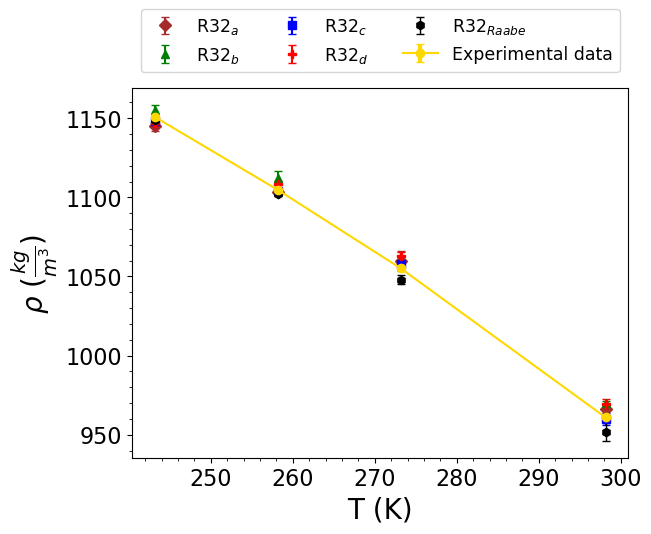

In [38]:
fig, ax = plt.subplots()

ax.errorbar(Temp_state_point, rho_final[0,:], yerr = rho_final_error[0,:], fmt='D',ecolor = 'brown',color='brown', label = 'R32$_{a}$', capsize=3)
ax.errorbar(Temp_state_point, rho_final[1,:], yerr = rho_final_error[1,:], fmt='^',ecolor = 'green',color='green', label = 'R32$_{b}$', capsize=3)
ax.errorbar(Temp_state_point, rho_final[2,:], yerr = rho_final_error[2,:], fmt='s',ecolor = 'blue',color='blue', label = 'R32$_{c}$', capsize=3)
ax.errorbar(Temp_state_point, rho_final[3,:], yerr = rho_final_error[3,:], fmt='P',ecolor = 'red',color='red', label = 'R32$_{d}$', capsize=3)
ax.errorbar(Temp_state_point,rho_final[4,:], yerr = rho_final_error[4,:], fmt='h',ecolor = 'black',color='black', elinewidth=1, label = 'R32$_{Raabe}$', capsize=3)
ax.errorbar(Temp_state_point, mass_density_exp, yerr = mass_density_exp_error, fmt='o-', ecolor = 'gold',color='gold', elinewidth=3, label = 'Experimental data', capsize=3) #fmt='o',
ax.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", mode="expand", ncol=3, fontsize=12.5)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
ax.minorticks_on()
plt.xlabel('T (K)', fontsize=20)
plt.ylabel(r'$\rho$' ' ' r'$(\frac{kg}{m^3})$', fontsize=20)

plt.savefig("R32_mass_density", dpi=1000, bbox_inches='tight')

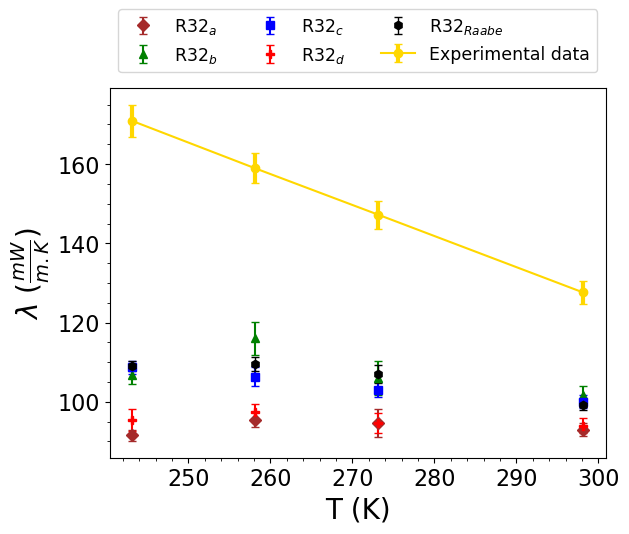

In [39]:
fig, ax = plt.subplots()

ax.errorbar(Temp_state_point, kappa_calc_values[0,:], yerr = kappa_calc_abserror[0,:], fmt='D',ecolor = 'brown',color='brown', label = 'R32$_{a}$', capsize=3)
ax.errorbar(Temp_state_point, kappa_calc_values[1,:], yerr = kappa_calc_abserror[1,:], fmt='^',ecolor = 'green',color='green', label = 'R32$_{b}$', capsize=3)
ax.errorbar(Temp_state_point, kappa_calc_values[2,:], yerr = kappa_calc_abserror[2,:], fmt='s',ecolor = 'blue',color='blue', label = 'R32$_{c}$', capsize=3)
ax.errorbar(Temp_state_point, kappa_calc_values[3,:], yerr = kappa_calc_abserror[3,:], fmt='P',ecolor = 'red',color='red', label = 'R32$_{d}$', capsize=3)
ax.errorbar(Temp_state_point,kappa_calc_values[4,:], yerr = kappa_calc_abserror[4,:], fmt='h',ecolor = 'black',color='black', elinewidth=1, label = 'R32$_{Raabe}$', capsize=3)
ax.errorbar(Temp_state_point, kappa_final_exp, yerr = kappa_final_exp_error, fmt='o-', ecolor = 'gold',color='gold', elinewidth=3, label = 'Experimental data', capsize=3) #fmt='o',
ax.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", mode="expand", ncol=3, fontsize=12.5)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
ax.minorticks_on()
plt.xlabel('T (K)', fontsize=20)
plt.ylabel('$\lambda$' ' ' r'$(\frac{mW}{m.K})$', fontsize=20)

plt.savefig("R32_therm_cond", dpi=1000, bbox_inches='tight')

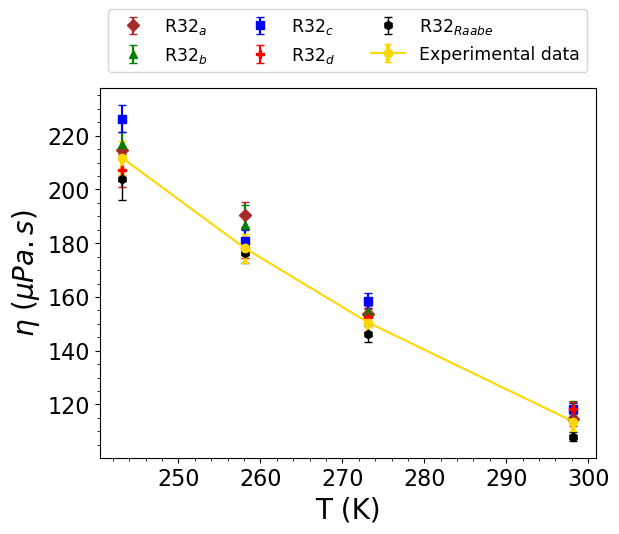

In [40]:
fig, ax = plt.subplots()

ax.errorbar(Temp_state_point, viscosity_calc_values[0,:]*1e6, yerr = viscosity_calc_abserror[0,:]*1e6, fmt='D',ecolor = 'brown',color='brown', label = 'R32$_{a}$', capsize=3)
ax.errorbar(Temp_state_point, viscosity_calc_values[1,:]*1e6, yerr = viscosity_calc_abserror[1,:]*1e6, fmt='^',ecolor = 'green',color='green', label = 'R32$_{b}$', capsize=3)
ax.errorbar(Temp_state_point, viscosity_calc_values[2,:]*1e6, yerr = viscosity_calc_abserror[2,:]*1e6, fmt='s',ecolor = 'blue',color='blue', label = 'R32$_{c}$', capsize=3)
ax.errorbar(Temp_state_point, viscosity_calc_values[3,:]*1e6, yerr = viscosity_calc_abserror[3,:]*1e6, fmt='P',ecolor = 'red',color='red', label = 'R32$_{d}$', capsize=3)
ax.errorbar(Temp_state_point,viscosity_calc_values[4,:]*1e6, yerr = viscosity_calc_abserror[4,:]*1e6, fmt='h',ecolor = 'black',color='black', elinewidth=1, label = 'R32$_{Raabe}$', capsize=3)
ax.errorbar(Temp_state_point, viscosity_NIST_exp, yerr = viscosity_NIST_exp_error, fmt='o-', ecolor = 'gold',color='gold', elinewidth=3, label = 'Experimental data', capsize=3) #fmt='o',
ax.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", mode="expand", ncol=3, fontsize=12.5)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
ax.minorticks_on()
plt.xlabel('T (K)', fontsize=20)
plt.ylabel('$\eta$' ' ' r'$(\mu Pa.s)$', fontsize=20)

plt.savefig("R32_viscosity", dpi=1000, bbox_inches='tight')

In [41]:
np.savetxt('R32_viscosity.txt', viscosity_calc_values)
np.savetxt('R32_viscosity_error.txt', viscosity_calc_abserror)

def box_length(density, number_of_particles, molar_mass):
  Avg_num = 6.022e23
  vol = ((molar_mass/Avg_num)/ density) * number_of_particles
  cubic_length = (vol**(1/3)) 
  return cubic_length

R32_length = box_length(rho_final, N, molar_mass_R32)
R32_length_error = R32_length * (rho_final_error/rho_final)

np.savetxt('R32_Lengths.txt', R32_length)
np.savetxt('R32_Lengths_error.txt', R32_length_error)

In [42]:
'''
fig, ax = plt.subplots()

ax.errorbar(Temp_state_point, rho_all[0,:], yerr = rho_error_all[0,:], fmt='D',ecolor = 'brown',color='brown', label = 'R32 v52', capsize=3)
ax.errorbar(Temp_state_point, rho_all[1,:], yerr = rho_error_all[1,:], fmt='^',ecolor = 'green',color='green', label = 'R32 v37', capsize=3)
ax.errorbar(Temp_state_point, rho_all[2,:], yerr = rho_error_all[2,:], fmt='s',ecolor = 'blue',color='blue', label = 'R32 v36', capsize=3)
ax.errorbar(Temp_state_point, rho_all[3,:], yerr = rho_error_all[3,:], fmt='P',ecolor = 'red',color='red', label = 'R32 v23', capsize=3)
ax.errorbar(Temp_state_point,rho_all[4,:], yerr = rho_error_all[4,:], fmt='h',ecolor = 'black',color='black', elinewidth=1, label = 'R32 vRAABE', capsize=3)
ax.errorbar(Temp_state_point, mass_density_exp, yerr = mass_density_exp_error, fmt='o-', ecolor = 'gold',color='gold', elinewidth=3, label = 'Experimental data', capsize=3) #fmt='o',
ax.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", mode="expand", ncol=3, fontsize=12.5)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
ax.minorticks_on()
plt.xlabel('T (K)', fontsize=20)
plt.ylabel(r'$\rho$' ' ' r'$(\frac{kg}{m^3})$', fontsize=20)
#plt.ylabel(r'$\alpha \times 10^{4}$' " " r'$(K^{-1})$', fontsize=20)
'''

'\nfig, ax = plt.subplots()\n\nax.errorbar(Temp_state_point, rho_all[0,:], yerr = rho_error_all[0,:], fmt=\'D\',ecolor = \'brown\',color=\'brown\', label = \'R32 v52\', capsize=3)\nax.errorbar(Temp_state_point, rho_all[1,:], yerr = rho_error_all[1,:], fmt=\'^\',ecolor = \'green\',color=\'green\', label = \'R32 v37\', capsize=3)\nax.errorbar(Temp_state_point, rho_all[2,:], yerr = rho_error_all[2,:], fmt=\'s\',ecolor = \'blue\',color=\'blue\', label = \'R32 v36\', capsize=3)\nax.errorbar(Temp_state_point, rho_all[3,:], yerr = rho_error_all[3,:], fmt=\'P\',ecolor = \'red\',color=\'red\', label = \'R32 v23\', capsize=3)\nax.errorbar(Temp_state_point,rho_all[4,:], yerr = rho_error_all[4,:], fmt=\'h\',ecolor = \'black\',color=\'black\', elinewidth=1, label = \'R32 vRAABE\', capsize=3)\nax.errorbar(Temp_state_point, mass_density_exp, yerr = mass_density_exp_error, fmt=\'o-\', ecolor = \'gold\',color=\'gold\', elinewidth=3, label = \'Experimental data\', capsize=3) #fmt=\'o\',\nax.legend(bbox_

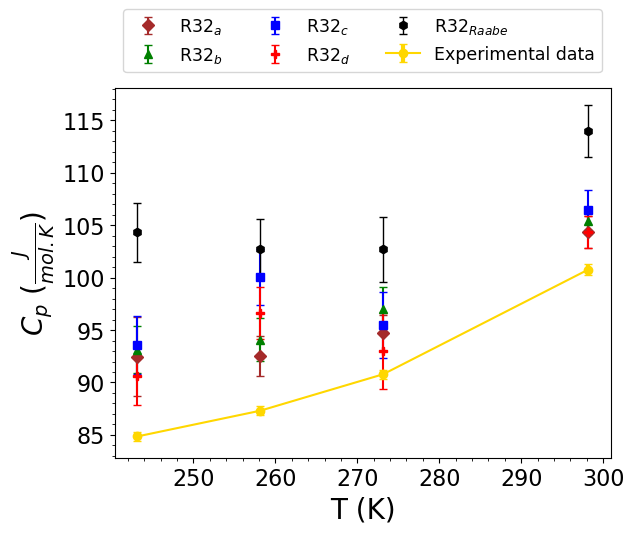

In [43]:

fig, ax = plt.subplots()

ax.errorbar(Temp_state_point, Cp_all[0,:], yerr = Cp_error_all[0,:], fmt='D',ecolor = 'brown',color='brown', label = 'R32$_{a}$', capsize=3)
ax.errorbar(Temp_state_point, Cp_all[1,:], yerr = Cp_error_all[1,:], fmt='^',ecolor = 'green',color='green', label = 'R32$_{b}$', capsize=3)
ax.errorbar(Temp_state_point, Cp_all[2,:], yerr = Cp_error_all[2,:], fmt='s',ecolor = 'blue',color='blue', label = 'R32$_{c}$', capsize=3)
ax.errorbar(Temp_state_point, Cp_all[3,:], yerr = Cp_error_all[3,:], fmt='P',ecolor = 'red',color='red', label = 'R32$_{d}$', capsize=3)
ax.errorbar(Temp_state_point,Cp_all[4,:], yerr = Cp_error_all[4,:], fmt='h',ecolor = 'black',color='black', elinewidth=1, label = 'R32$_{Raabe}$', capsize=3)
ax.errorbar(Temp_state_point, Cp_exp, yerr = Cp_exp_error, fmt='o-', ecolor = 'gold',color='gold', elinewidth=3, label = 'Experimental data', capsize=3) #fmt='o',
ax.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", mode="expand", ncol=3, fontsize=12.5)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
ax.minorticks_on()
plt.xlabel('T (K)', fontsize=20)
plt.ylabel('$C_{p}$' ' ' r'$(\frac{J}{mol.K})$', fontsize=20)

plt.savefig("R32_Cp", dpi=1000, bbox_inches='tight')

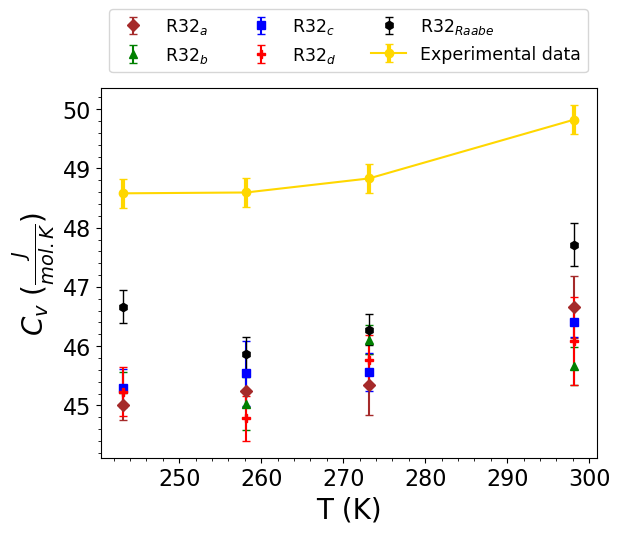

In [44]:

fig, ax = plt.subplots()

ax.errorbar(Temp_state_point, Cv_all[0,:], yerr = Cv_error_all[0,:], fmt='D',ecolor = 'brown',color='brown', label = 'R32$_{a}$', capsize=3)
ax.errorbar(Temp_state_point, Cv_all[1,:], yerr = Cv_error_all[1,:], fmt='^',ecolor = 'green',color='green', label = 'R32$_{b}$', capsize=3)
ax.errorbar(Temp_state_point, Cv_all[2,:], yerr = Cv_error_all[2,:], fmt='s',ecolor = 'blue',color='blue', label = 'R32$_{c}$', capsize=3)
ax.errorbar(Temp_state_point, Cv_all[3,:], yerr = Cv_error_all[3,:], fmt='P',ecolor = 'red',color='red', label = 'R32$_{d}$', capsize=3)
ax.errorbar(Temp_state_point,Cv_all[4,:], yerr = Cv_error_all[4,:], fmt='h',ecolor = 'black',color='black', elinewidth=1, label = 'R32$_{Raabe}$', capsize=3)
ax.errorbar(Temp_state_point, Cv_exp, yerr = Cv_exp_error, fmt='o-', ecolor = 'gold',color='gold', elinewidth=3, label = 'Experimental data', capsize=3) #fmt='o',
ax.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", mode="expand", ncol=3, fontsize=12.5)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
ax.minorticks_on()
plt.xlabel('T (K)', fontsize=20)
plt.ylabel('$C_{v}$' ' ' r'$(\frac{J}{mol.K})$', fontsize=20)

plt.savefig("R32_Cv", dpi=1000, bbox_inches='tight')

In [45]:
'''
Cp_ideal_final = np.array([82.195  ,     85.130   ,   88.000   ,   92.645])
Cp_res_final = Cp_final - Cp_ideal_final

Cp_ideal_exp = np.array([83.478    ,   86.553  ,    89.561  ,    94.429])
Cp_res_exp = Cp_exp - Cp_ideal_exp
'''

'\nCp_ideal_final = np.array([82.195  ,     85.130   ,   88.000   ,   92.645])\nCp_res_final = Cp_final - Cp_ideal_final\n\nCp_ideal_exp = np.array([83.478    ,   86.553  ,    89.561  ,    94.429])\nCp_res_exp = Cp_exp - Cp_ideal_exp\n'

In [46]:
'''
fig, ax = plt.subplots()

ax.errorbar(Temp_state_point, Cp_res_final[0,:], yerr = Cp_final_error[0,:], fmt='D',ecolor = 'brown',color='brown', label = 'R32 v52', capsize=3)
ax.errorbar(Temp_state_point, Cp_res_final[1,:], yerr = Cp_final_error[1,:], fmt='^',ecolor = 'green',color='green', label = 'R32 v37', capsize=3)
ax.errorbar(Temp_state_point, Cp_res_final[2,:], yerr = Cp_final_error[2,:], fmt='s',ecolor = 'blue',color='blue', label = 'R32 v36', capsize=3)
ax.errorbar(Temp_state_point, Cp_res_final[3,:], yerr = Cp_final_error[3,:], fmt='P',ecolor = 'red',color='red', label = 'R32 v23', capsize=3)
ax.errorbar(Temp_state_point,Cp_res_final[4,:], yerr = Cp_final_error[4,:], fmt='h',ecolor = 'black',color='black', elinewidth=1, label = 'R32 vRAABE', capsize=3)
ax.errorbar(Temp_state_point, Cp_res_exp, yerr = Cp_res_exp*0.005, fmt='o-', ecolor = 'gold',color='gold', elinewidth=3, label = 'Experimental data', capsize=3) #fmt='o',
ax.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", mode="expand", ncol=3, fontsize=12.5)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
ax.minorticks_on()
plt.xlabel('T (K)', fontsize=20)
plt.ylabel('$C_{p_{res}}$' ' ' r'$(\frac{J}{mol.K})$', fontsize=20)
'''

'\nfig, ax = plt.subplots()\n\nax.errorbar(Temp_state_point, Cp_res_final[0,:], yerr = Cp_final_error[0,:], fmt=\'D\',ecolor = \'brown\',color=\'brown\', label = \'R32 v52\', capsize=3)\nax.errorbar(Temp_state_point, Cp_res_final[1,:], yerr = Cp_final_error[1,:], fmt=\'^\',ecolor = \'green\',color=\'green\', label = \'R32 v37\', capsize=3)\nax.errorbar(Temp_state_point, Cp_res_final[2,:], yerr = Cp_final_error[2,:], fmt=\'s\',ecolor = \'blue\',color=\'blue\', label = \'R32 v36\', capsize=3)\nax.errorbar(Temp_state_point, Cp_res_final[3,:], yerr = Cp_final_error[3,:], fmt=\'P\',ecolor = \'red\',color=\'red\', label = \'R32 v23\', capsize=3)\nax.errorbar(Temp_state_point,Cp_res_final[4,:], yerr = Cp_final_error[4,:], fmt=\'h\',ecolor = \'black\',color=\'black\', elinewidth=1, label = \'R32 vRAABE\', capsize=3)\nax.errorbar(Temp_state_point, Cp_res_exp, yerr = Cp_res_exp*0.005, fmt=\'o-\', ecolor = \'gold\',color=\'gold\', elinewidth=3, label = \'Experimental data\', capsize=3) #fmt=\'o\'

In [47]:
'''
fig, ax = plt.subplots()

ax.errorbar(Temp_state_point, thermal_expans_all[0,:]*1e4, yerr = thermal_expans_error_all[0,:]*1e4, fmt='D',ecolor = 'brown',color='brown', label = 'R32 v52', capsize=3)
ax.errorbar(Temp_state_point, thermal_expans_all[1,:]*1e4, yerr = thermal_expans_error_all[1,:]*1e4, fmt='^',ecolor = 'green',color='green', label = 'R32 v37', capsize=3)
ax.errorbar(Temp_state_point, thermal_expans_all[2,:]*1e4, yerr = thermal_expans_error_all[2,:]*1e4, fmt='s',ecolor = 'blue',color='blue', label = 'R32 v36', capsize=3)
ax.errorbar(Temp_state_point, thermal_expans_all[3,:]*1e4, yerr = thermal_expans_error_all[3,:]*1e4, fmt='P',ecolor = 'red',color='red', label = 'R32 v23', capsize=3)
ax.errorbar(Temp_state_point,thermal_expans_all[4,:]*1e4, yerr = thermal_expans_error_all[4,:]*1e4, fmt='h',ecolor = 'black',color='black', elinewidth=1, label = 'R32 vRAABE', capsize=3)
ax.errorbar(Temp_state_point, thermal_expans_exp*1e4, yerr = thermal_expans_exp_error*1e4, ecolor = 'gold',color='gold', elinewidth=3, capsize=3, label = 'Experimental data') 
ax.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", mode="expand", ncol=3, fontsize=12.5)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.text(242, 50, 'linear Fit', fontsize = 20)
ax.minorticks_on()
plt.xlabel('T (K)', fontsize=20)
plt.ylabel(r'$\alpha \times 10^{4}$' " " r'$(K^{-1})$', fontsize=20)
'''


'\nfig, ax = plt.subplots()\n\nax.errorbar(Temp_state_point, thermal_expans_all[0,:]*1e4, yerr = thermal_expans_error_all[0,:]*1e4, fmt=\'D\',ecolor = \'brown\',color=\'brown\', label = \'R32 v52\', capsize=3)\nax.errorbar(Temp_state_point, thermal_expans_all[1,:]*1e4, yerr = thermal_expans_error_all[1,:]*1e4, fmt=\'^\',ecolor = \'green\',color=\'green\', label = \'R32 v37\', capsize=3)\nax.errorbar(Temp_state_point, thermal_expans_all[2,:]*1e4, yerr = thermal_expans_error_all[2,:]*1e4, fmt=\'s\',ecolor = \'blue\',color=\'blue\', label = \'R32 v36\', capsize=3)\nax.errorbar(Temp_state_point, thermal_expans_all[3,:]*1e4, yerr = thermal_expans_error_all[3,:]*1e4, fmt=\'P\',ecolor = \'red\',color=\'red\', label = \'R32 v23\', capsize=3)\nax.errorbar(Temp_state_point,thermal_expans_all[4,:]*1e4, yerr = thermal_expans_error_all[4,:]*1e4, fmt=\'h\',ecolor = \'black\',color=\'black\', elinewidth=1, label = \'R32 vRAABE\', capsize=3)\nax.errorbar(Temp_state_point, thermal_expans_exp*1e4, yerr 

In [48]:
'''
fig, ax = plt.subplots()

ax.errorbar(Temp_state_point, TEC_cubic_EOS[0,:]*1e4 , fmt='D' ,color='brown', label = 'R32 v52')
ax.errorbar(Temp_state_point, TEC_cubic_EOS[1,:]*1e4 , fmt='^' ,color='green', label = 'R32 v37')
ax.errorbar(Temp_state_point, TEC_cubic_EOS[2,:]*1e4 , fmt='s' ,color='blue', label = 'R32 v36')
ax.errorbar(Temp_state_point, TEC_cubic_EOS[3,:]*1e4 , fmt='P' ,color='red', label = 'R32 v23')
ax.errorbar(Temp_state_point,TEC_cubic_EOS[4,:]*1e4 , fmt='h'  ,color='black', label = 'R32 vRAABE')
ax.errorbar(Temp_state_point, thermal_expans_exp*1e4, color='gold', label = 'Experimental data') 
ax.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", mode="expand", ncol=3, fontsize=12.5)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.text(242, 50, 'Cubic Polynomial Fit', fontsize = 20)
ax.minorticks_on()
plt.xlabel('T (K)', fontsize=20)
plt.ylabel(r'$\alpha \times 10^{4}$' " " r'$(K^{-1})$', fontsize=20)
'''

'\nfig, ax = plt.subplots()\n\nax.errorbar(Temp_state_point, TEC_cubic_EOS[0,:]*1e4 , fmt=\'D\' ,color=\'brown\', label = \'R32 v52\')\nax.errorbar(Temp_state_point, TEC_cubic_EOS[1,:]*1e4 , fmt=\'^\' ,color=\'green\', label = \'R32 v37\')\nax.errorbar(Temp_state_point, TEC_cubic_EOS[2,:]*1e4 , fmt=\'s\' ,color=\'blue\', label = \'R32 v36\')\nax.errorbar(Temp_state_point, TEC_cubic_EOS[3,:]*1e4 , fmt=\'P\' ,color=\'red\', label = \'R32 v23\')\nax.errorbar(Temp_state_point,TEC_cubic_EOS[4,:]*1e4 , fmt=\'h\'  ,color=\'black\', label = \'R32 vRAABE\')\nax.errorbar(Temp_state_point, thermal_expans_exp*1e4, color=\'gold\', label = \'Experimental data\') \nax.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", mode="expand", ncol=3, fontsize=12.5)\nplt.yticks(fontsize=16)\nplt.xticks(fontsize=16)\nplt.text(242, 50, \'Cubic Polynomial Fit\', fontsize = 20)\nax.minorticks_on()\nplt.xlabel(\'T (K)\', fontsize=20)\nplt.ylabel(r\'$\x07lpha \times 10^{4}$\' " " r\'$(K^{-1})$\', fontsize=20)

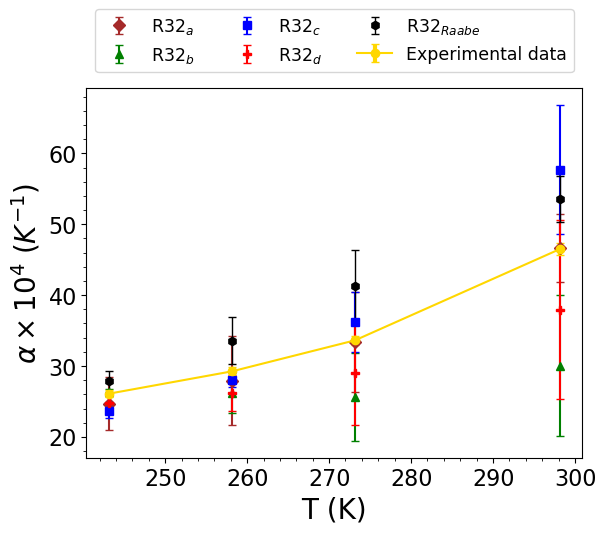

In [49]:
fig, ax = plt.subplots()

ax.errorbar(Temp_state_point, TEC_cubic_EOS[0,:]*1e4, yerr = TEC_cubic_EOS_error[0,:]*1e4, fmt='D',ecolor = 'brown',color='brown', label = 'R32$_{a}$', capsize=3)
ax.errorbar(Temp_state_point, TEC_cubic_EOS[1,:]*1e4, yerr = TEC_cubic_EOS_error[1,:]*1e4, fmt='^',ecolor = 'green',color='green', label = 'R32$_{b}$', capsize=3)
ax.errorbar(Temp_state_point, TEC_cubic_EOS[2,:]*1e4, yerr = TEC_cubic_EOS_error[2,:]*1e4, fmt='s',ecolor = 'blue',color='blue', label = 'R32$_{c}$', capsize=3)
ax.errorbar(Temp_state_point, TEC_cubic_EOS[3,:]*1e4, yerr = TEC_cubic_EOS_error[3,:]*1e4, fmt='P',ecolor = 'red',color='red', label = 'R32$_{d}$', capsize=3)
ax.errorbar(Temp_state_point,TEC_cubic_EOS[4,:]*1e4, yerr = TEC_cubic_EOS_error[4,:]*1e4, fmt='h',ecolor = 'black',color='black', elinewidth=1, label = 'R32$_{Raabe}$', capsize=3)
ax.errorbar(Temp_state_point, thermal_expans_exp*1e4, yerr = thermal_expans_exp_error*1e4, fmt='o-', ecolor = 'gold',color='gold', elinewidth=3, capsize=3, label = 'Experimental data') 
ax.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", mode="expand", ncol=3, fontsize=12.5)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
#plt.text(242, 50, 'Cubic Fit of ' r'$\rho PT$ data' , fontsize = 20)
ax.minorticks_on()
plt.xlabel('T (K)', fontsize=20)
plt.ylabel(r'$\alpha \times 10^{4}$' " " r'$(K^{-1})$', fontsize=20)

plt.savefig("R32_TEC", dpi=1000, bbox_inches='tight')

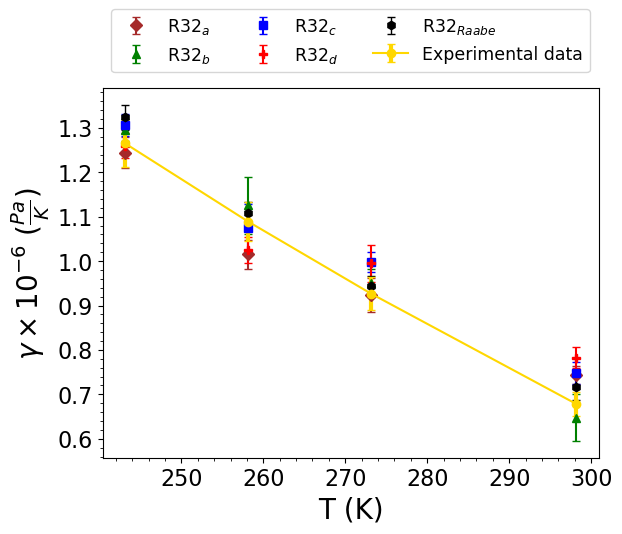

In [50]:
fig, ax = plt.subplots()

ax.errorbar(Temp_state_point, TPC_all[0,:]*1e-6, yerr = TPC_error_all[0,:]*1e-6, fmt='D',ecolor = 'brown',color='brown', label = 'R32$_{a}$', capsize=3)
ax.errorbar(Temp_state_point, TPC_all[1,:]*1e-6, yerr = TPC_error_all[1,:]*1e-6, fmt='^',ecolor = 'green',color='green', label = 'R32$_{b}$', capsize=3)
ax.errorbar(Temp_state_point, TPC_all[2,:]*1e-6, yerr = TPC_error_all[2,:]*1e-6, fmt='s',ecolor = 'blue',color='blue', label = 'R32$_{c}$', capsize=3)
ax.errorbar(Temp_state_point, TPC_all[3,:]*1e-6, yerr = TPC_error_all[3,:]*1e-6, fmt='P',ecolor = 'red',color='red', label = 'R32$_{d}$', capsize=3)
ax.errorbar(Temp_state_point,TPC_all[4,:]*1e-6, yerr = TPC_error_all[4,:]*1e-6, fmt='h',ecolor = 'black',color='black', elinewidth=1, label = 'R32$_{Raabe}$', capsize=3)
ax.errorbar(Temp_state_point, TPC_exp*1e-6, yerr = TPC_exp_error*1e-6, fmt='o-', ecolor = 'gold',color='gold', elinewidth=3, label = 'Experimental data', capsize=3) #fmt='o',
ax.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", mode="expand", ncol=3, fontsize=12.5)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
ax.minorticks_on()
plt.xlabel('T (K)', fontsize=20)
plt.ylabel(r'$\gamma \times 10^{-6}$' " " r'$(\frac{Pa}{K})$', fontsize=20)

plt.savefig("R32_TPC", dpi=1000, bbox_inches='tight')

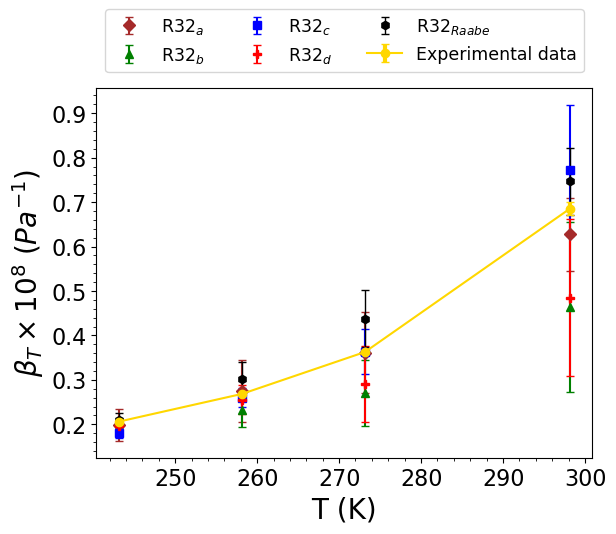

In [62]:
fig, ax = plt.subplots()

ax.errorbar(Temp_state_point, IC_all[0,:]*1e8, yerr = IC_all_error[0,:]*1e8, fmt='D',ecolor = 'brown',color='brown', label = 'R32$_{a}$', capsize=3)
ax.errorbar(Temp_state_point, IC_all[1,:]*1e8, yerr = IC_all_error[1,:]*1e8, fmt='^',ecolor = 'green',color='green', label = 'R32$_{b}$', capsize=3)
ax.errorbar(Temp_state_point, IC_all[2,:]*1e8, yerr = IC_all_error[2,:]*1e8, fmt='s',ecolor = 'blue',color='blue', label = 'R32$_{c}$', capsize=3)
ax.errorbar(Temp_state_point, IC_all[3,:]*1e8, yerr = IC_all_error[3,:]*1e8, fmt='P',ecolor = 'red',color='red', label = 'R32$_{d}$', capsize=3)
ax.errorbar(Temp_state_point,IC_all[4,:]*1e8, yerr = IC_all_error[4,:]*1e8, fmt='h',ecolor = 'black',color='black', elinewidth=1, label = 'R32$_{Raabe}$', capsize=3)
ax.errorbar(Temp_state_point, iso_compress_exp*1e8, yerr = iso_compress_exp_error*1e8, fmt='o-', ecolor = 'gold',color='gold', elinewidth=3, capsize=3, label = 'Experimental data') 
ax.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", mode="expand", ncol=3, fontsize=12.5)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
#plt.text(242, 1.25, 'IC = TEC/TPC, TPC obtained from NVT', fontsize = 14)
#plt.text(242, 1.05, 'TPC from NVT', fontsize = 14)
ax.minorticks_on()
plt.xlabel('T (K)', fontsize=20)
plt.ylabel(r'$\beta_{T} \times 10^{8}$' " " r'$(Pa^{-1})$', fontsize=20)

plt.savefig("R32_IC", dpi=1000, bbox_inches='tight')

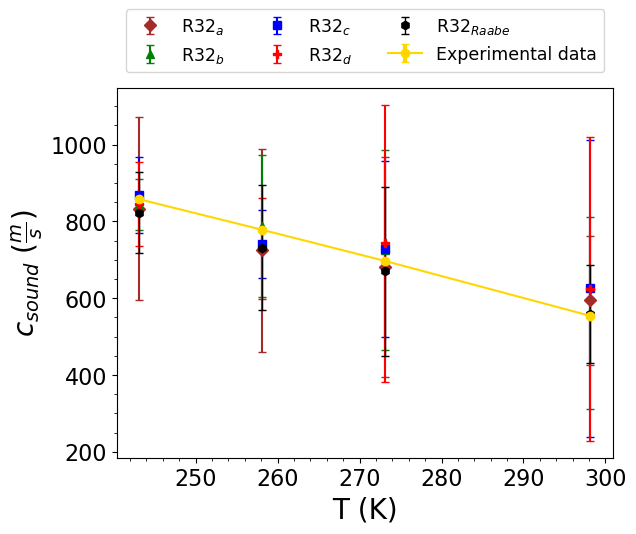

In [52]:
fig, ax = plt.subplots()

ax.errorbar(Temp_state_point, c_sound_all[0,:], yerr = c_sound_all_error[0,:], fmt='D',ecolor = 'brown',color='brown', label = 'R32$_{a}$', capsize=3)
ax.errorbar(Temp_state_point, c_sound_all[1,:], yerr = c_sound_all_error[1,:], fmt='^',ecolor = 'green',color='green', label = 'R32$_{b}$', capsize=3)
ax.errorbar(Temp_state_point, c_sound_all[2,:], yerr = c_sound_all_error[2,:], fmt='s',ecolor = 'blue',color='blue', label = 'R32$_{c}$', capsize=3)
ax.errorbar(Temp_state_point, c_sound_all[3,:], yerr = c_sound_all_error[3,:], fmt='P',ecolor = 'red',color='red', label = 'R32$_{d}$', capsize=3)
ax.errorbar(Temp_state_point,c_sound_all[4,:], yerr = c_sound_all_error[4,:], fmt='h',ecolor = 'black',color='black', elinewidth=1, label = 'R32$_{Raabe}$', capsize=3)
ax.errorbar(Temp_state_point, speed_sound_exp, yerr = speed_sound_exp_error, fmt='o-', ecolor = 'gold',color='gold', elinewidth=3, capsize=3, label = 'Experimental data') 
ax.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", mode="expand", ncol=3, fontsize=12.5)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
ax.minorticks_on()
plt.xlabel('T (K)', fontsize=20)
plt.ylabel(r'$c_{sound}$' " " r'$(\frac{m}{s})$', fontsize=20)


plt.savefig("R32_speed_sound", dpi=1000, bbox_inches='tight')

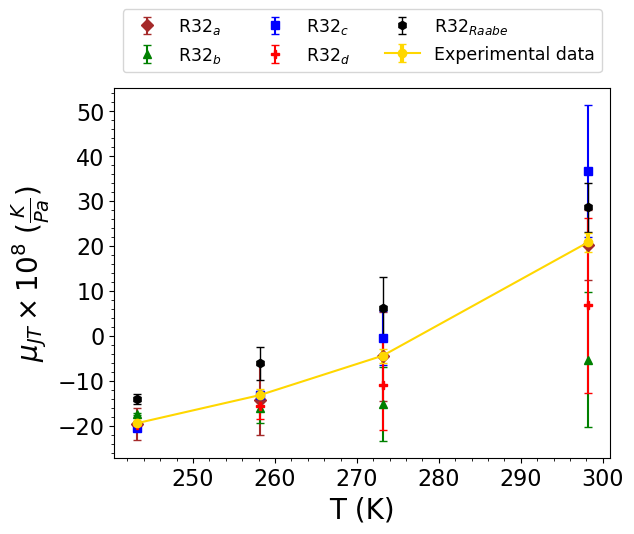

In [53]:
fig, ax = plt.subplots()

ax.errorbar(Temp_state_point, mhu_jt_all[0,:]*1e8, yerr = mhu_jt_all_error[0,:]*1e8, fmt='D',ecolor = 'brown',color='brown', label = 'R32$_{a}$', capsize=3)
ax.errorbar(Temp_state_point, mhu_jt_all[1,:]*1e8, yerr = mhu_jt_all_error[1,:]*1e8, fmt='^',ecolor = 'green',color='green', label = 'R32$_{b}$', capsize=3)
ax.errorbar(Temp_state_point, mhu_jt_all[2,:]*1e8, yerr = mhu_jt_all_error[2,:]*1e8, fmt='s',ecolor = 'blue',color='blue', label = 'R32$_{c}$', capsize=3)
ax.errorbar(Temp_state_point, mhu_jt_all[3,:]*1e8, yerr = mhu_jt_all_error[3,:]*1e8, fmt='P',ecolor = 'red',color='red', label = 'R32$_{d}$', capsize=3)
ax.errorbar(Temp_state_point, mhu_jt_all[4,:]*1e8, yerr = mhu_jt_all_error[4,:]*1e8, fmt='h',ecolor = 'black',color='black', elinewidth=1, label = 'R32$_{Raabe}$', capsize=3)
ax.errorbar(Temp_state_point, mhu_jt_exp*1e8, yerr = mhu_jt_exp_error*1e8, fmt='o-', ecolor = 'gold',color='gold', elinewidth=3, capsize=3, label = 'Experimental data') 
ax.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", mode="expand", ncol=3, fontsize=12.5)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
ax.minorticks_on()
plt.xlabel('T (K)', fontsize=20)
plt.ylabel(r'$\mu_{JT} \times 10^{8}$' " " r'$(\frac{K}{Pa})$', fontsize=20)

plt.savefig("R32_Joule_thoms_coeff", dpi=1000, bbox_inches='tight')

# FF RANKING

In [54]:
def total_mape(sim,exp):
  ape = (np.abs(exp-sim)/np.abs(exp))*100
  mape = np.mean(ape)
  return mape

In [55]:
num_ranktable_rows = 14
mape_table = np.zeros((num_ranktable_rows, len(versions)))

for i in range(len(versions)):
  mape_table[0,i] = total_mape(kappa_calc_values[i,:], kappa_final_exp)

for i in range(len(versions)):
  mape_table[1,i] = total_mape(viscosity_calc_values[i,:]*1e6, viscosity_NIST_exp)

for i in range(len(versions)):
  mape_table[2,i] = total_mape(Cp_all[i,:], Cp_exp)

for i in range(len(versions)):
  mape_table[3,i] = total_mape(Cv_all[i,:], Cv_exp)

for i in range(len(versions)):
  mape_table[4,i] = total_mape(TEC_cubic_EOS[i,:], thermal_expans_exp)

for i in range(len(versions)):
  mape_table[5,i] = total_mape(TPC_all[i,:], TPC_exp)

for i in range(len(versions)):
  mape_table[6,i] = total_mape(IC_all[i,:], iso_compress_exp)

for i in range(len(versions)):
  mape_table[7,i] = total_mape(c_sound_all[i,:], speed_sound_exp)

for i in range(len(versions)):
  mape_table[8,i] = total_mape(mhu_jt_all[i,:], mhu_jt_exp)

for i in range(len(versions)):
  mape_table[9,i] = np.mean(mape_table[1:6, i])

for i in range(len(versions)):
  mape_table[10,i] = np.mean(mape_table[0:6, i])

for i in range(len(versions)):
  mape_table[11,i] = np.mean(mape_table[0:8, i])

for i in range(len(versions)):
  mape_table[12,i] = np.mean(mape_table[0:9, i])

In [56]:
mape_table_1 = pd.DataFrame(mape_table)

rank = mape_table_1.iloc[10,:].rank( method='min')

rank = rank.astype(int)

rank = rank.astype(str)

In [57]:
mape_table[13,:] = rank

mape_table_ranking = pd.DataFrame(mape_table)

#mape_table_ranking.index =['$\lambda$', 'Viscosity', 'Cp', 'Cv', 'TEC', 'TPC', 'IC', 'Speed_sound', 'JTC','Ave_Sim_no_Therm_Cond', \
#                           'Ave_Simulation_all','Ave_no_JTC',  'Ave_all', 'Rank']

mape_table_ranking.index = [
'$\lambda$' ,
'$\eta$' ,
'$C_{p}$',
'$C_{v}$',
r'$\alpha_{P}$',
'$\gamma_{\rho}$',
r'$\beta_{T}$',
'$c_{sound}$',
'$\mu_{JT}$',
'Averages for DSPs without $\lambda$',
'Averages for all DSPs',
'Averages for all except $\mu_{JT}$',
'Averages for all',
'Rank  based on all DSPs'
]             

mape_table_ranking.columns = ['0', '1', '2', '3', 'ref']

mape_table_ranking = mape_table_ranking.round(2)


# Surround the minimum value in each row with \textbfcurly braces
mape_table_ranking_edit = mape_table_ranking.apply(lambda row: [f"\textbf{{{min(row)}}}" \
                    if x == min(row) else x for x in row], axis=1, result_type='expand')


add_ampersand = lambda x: f"&{x}"

# Apply the function to each element in the data frame
mape_table_ranking_edit_more = mape_table_ranking_edit.applymap(add_ampersand)


mape_table_ranking_edit_more['slashes'] = mape_table_ranking_edit_more.apply(lambda x: '\\\\', axis=1)

print(mape_table_ranking_edit_more)

with open("R32 FFs ranking.txt", 'a') as f:
    mape_table_ranking_edit_more_string = mape_table_ranking_edit_more.to_string(header=True, index=True)
    f.write(mape_table_ranking_edit_more_string)

                                                  0                1       2  \
$\lambda$                                    &37.28  &\textbf{28.18}  &30.26   
$\eta$                                        &2.83            &3.66   &4.51   
$C_{p}$                               &\textbf{5.7}            &7.23    &8.9   
$C_{v}$                                       &6.92            &7.01   &6.64   
$\alpha_{P}$                         &\textbf{2.72}           &17.57  &11.42   
$\gamma_{\rho}$                               &4.56   &\textbf{3.21}   &5.59   
$\beta_{T}$                          &\textbf{3.76}           &18.16   &7.06   
$c_{sound}$                                   &4.82   &\textbf{2.11}   &5.88   
$\mu_{JT}$                           &\textbf{3.44}            &99.8   &42.8   
Averages for DSPs without $\lambda$  &\textbf{4.55}            &7.74   &7.41   
Averages for all DSPs                &\textbf{10.0}           &11.14  &11.22   
Averages for all except $\mu_{JT}$   &\t